# Un peu d'Exploratory Data Analysis avant toutes choses

Ce notebook vise à explorer rapidement la base de données pour avoir une idée de se composition, la répartition et éventuels déséquilibres entre les classes, les caractéristiques des textes à analyser. Cela est éventuellement l'occasion de détecter des erreurs de textes (encodage erroné au moment d'enregistrer/lire les demandes)

# 1. Packages usuels et importation de la base train

In [13]:
# Pour faciliter la mise à jour des fonctions écrites dans func_custom sans avoir à redémarrer le kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Packages classiques
import pandas as pd

# Custom package
import func_custom as fc

# NLP
from wordcloud import WordCloud
from nltk.corpus import stopwords

# Dataviz
import seaborn as sns
import matplotlib.pyplot as plt

La variable `Unnamed: 0` semble juste être un indice de ligne, on peut pour le moment ne pas le garder pour l'analyse

In [17]:
df_train = pd.read_excel("data/data_train.xlsx",
                         usecols = ["label", "message"],
                         index_col = False)

# 2. Quelques rapides statistiques et informations

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    700 non-null    object
 1   message  700 non-null    object
dtypes: object(2)
memory usage: 11.1+ KB


Il n'y a _a priori_ pas de valeurs nulles dans l'échantillon. Peut-être tous les messages ne sont-ils cependant pas exploitables (erreur d'encodage), nous explorerons cela plus tard.

In [19]:
df_train.head()

,label,message
0,8,"Madame,Monsieur, je me permet de vous envoyer ..."
1,8,je désire connaitre quel est le montant de mo...
2,8,"Bonjour, Je fais suite du dernier message envo..."
3,8,"Bonjour, Je me permets de vous contacter afin ..."
4,8,"Madame, Monsieur, Après avoir déclaré nos r..."


## 2.1 Exploration `label`

In [20]:
df_train["label"].value_counts()

8      309
1      302
1:8     89
Name: label, dtype: int64

On constate que l'échantillon est équilibré entre les classes 1 et 8, il n'y a pas de déséquilibres et donc les techniques de prises en charge d'_imbalanced dataset_ ne sont pas nécessaires :
- Upsampling/downsampling voire SMOTE pour augmentation synthétique
- Changement de la métrique à retenir

## 2.2 Exploration des `message`

Regardons plusieurs explorations de base des messages :
- Longueur des chaînes
- Premier wordcloud
- etcetc

In [39]:
# Générateur aléatoire de messages pour première inspection visuelle
df_train.sample(1)["message"].values[0]

"Bonjour, Je vais déclarer un changement de ma situation familiale, faut-il dès à présent remplir les données sur nos revenus 0000 ou est-ce que cela sera fait uniquement lors de la prochaine déclaration de nos revenus en mai 0000 ? Merci d'avance pour votre réponse. Bien cordialement, XXXXX XXXXX"

In [40]:
# Quelques fonctions simples pour caractériser les messages, et comparer d'éventuelles différences entre les labels
df_train["len_message"] = df_train["message"].apply(len)
df_train["count_words"] = df_train["message"].apply(lambda x: fc.count_words(x))

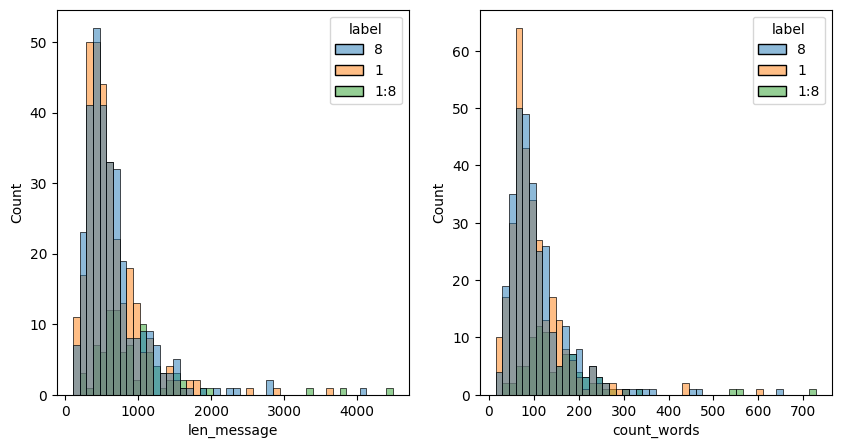

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

_ = sns.histplot(data = df_train,
                 ax = axes[0],
                 x = "len_message",
                 hue = "label")

_ = sns.histplot(data = df_train,
                 ax = axes[1],
                 x = "count_words",
                 hue = "label")

In [90]:
text_column_label1 = df_train[df_train["label"] == "1"]["message"]
text_column_label8 = df_train[df_train["label"] == "8"]["message"]

# Concaténer tous les textes dans cette colonne en une seule chaîne de caractères
text = ' '.join(text_column_label1.dropna())

In [92]:
stop_words_french = stopwords.words('french')
stop_words_custom = ["XXXXX", "Merci", "vement", "donc", "j'ai", "a", "e",  "faire", "fait", "alors", "l'XXXXX", "cette"]
stop_words_french.extend(stop_words_custom)

In [93]:
wordcloud = WordCloud(background_color = 'white',
                      stopwords =  stop_words_french,
                      max_words = 50).generate(text)

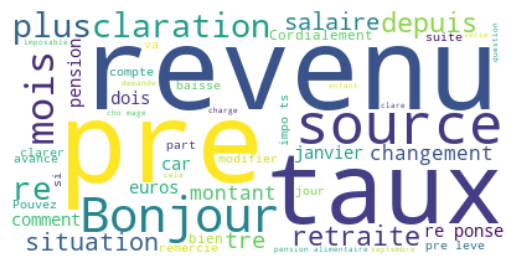

In [94]:
# Affichage du nuage de mots
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()